In [ ]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from island_ga import IslandGGA 
from chromosome import Chromosome 
import itertools

In [ ]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [ ]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())

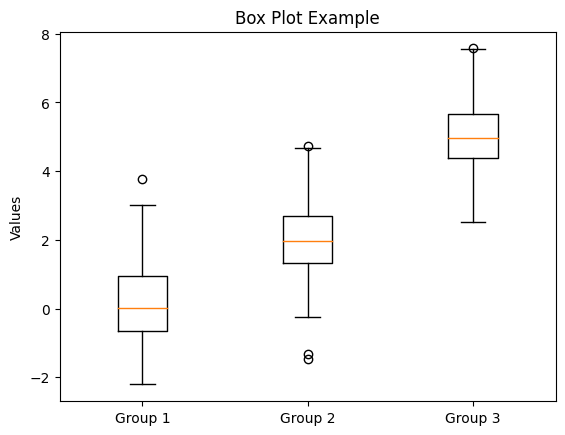

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data for three groups
data1 = np.random.normal(0, 1, size=100)
data2 = np.random.normal(2, 1, size=100)
data3 = np.random.normal(5, 1, size=100)

# Combine the data into a list
data = [data1, data2, data3]

# Create a box plot
fig, ax = plt.subplots()
ax.boxplot(data)

# Set the x-axis tick labels
ax.set_xticklabels(['Group 1', 'Group 2', 'Group 3'])

# Set the y-axis label
ax.set_ylabel('Values')

# Set the title of the plot
ax.set_title('Box Plot Example')

# Show the plot
plt.show()


In [ ]:
# ring
values = []
number_of_islands =[2, 4, 6, 8, 10]

for i in number_of_islands:
    ga = IslandGGA(data=train_data,num_islands=i,m_iter=20,num_iter=80,n_migrants=30,pSize=200,r_cross=0.1,r_mut=0.1,strategies=strategies,evolve_strategy="ring")
    ga.evolve()
    #v =  [i[2] for i in ga.convergence_values]
    #values.append(v)
    values.append(ga.convergence_values)
# convergence values for each mutation rate
convergence_values = values
# plot the convergence values for each mutation rate
plt.figure(figsize=(8, 6))
for i in range(len(number_of_islands)):
    plt.plot(np.arange(1, 81), convergence_values[i], label='Number of Islands = ' + str(number_of_islands[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different islands')
plt.legend()
plt.show()

In [ ]:
# multikuti
values = []
number_of_islands =[0.01, 0.05, 0.1, 0.3, 0.5]

for i in number_of_islands:
    ga = IslandGGA(data=train_data,num_islands=i,m_iter=20,num_iter=80,n_migrants=30,pSize=200,r_cross=0.1,r_mut=0.1,strategies=strategies,evolve_strategy="ring")
    ga.evolve()
    #v =  [i[2] for i in ga.convergence_values]
    #values.append(v)
    values.append(ga.convergence_values)
# convergence values for each mutation rate
convergence_values = values
# plot the convergence values for each mutation rate
plt.figure(figsize=(8, 6))
for i in range(len(number_of_islands)):
    plt.plot(np.arange(1, 81), convergence_values[i], label='Number of Islands = ' + str(number_of_islands[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different islands')
plt.legend()
plt.show()